<!-- dom:TITLE: Demo - Lid driven cavity -->
# Demo - Lid driven cavity
<!-- dom:AUTHOR: Mikael Mortensen Email:mikaem@math.uio.no at Department of Mathematics, University of Oslo. -->
<!-- Author: -->  
**Mikael Mortensen** (email: `mikaem@math.uio.no`), Department of Mathematics, University of Oslo.

Date: **May 6, 2019**

**Summary.** The lid driven cavity is a classical benchmark for Navier Stokes solvers.
This is a demonstration of how the Python module [shenfun](https://github.com/spectralDNS/shenfun) can be used to solve the lid
driven cavity problem with full spectral accuracy using a mixed (coupled) basis
in a 2D tensor product domain. The demo also shows how to use mixed
tensor product spaces for vector valued equations. Note that the regular
lid driven cavity, where the top wall has constant velocity and the
remaining three walls are stationary, has a singularity at the two
upper corners, where the velocity is discontinuous.
Due to their global nature, spectral methods
are usually not very good at handling problems with discontinuities, and
for this reason we will also look at a regularized lid driven cavity,
where the top lid moves according to $(1-x)^2(1+x)^2$, thus removing
the corner discontinuities.










<!-- dom:FIGURE: [https://raw.githack.com/spectralDNS/spectralutilities/master/figures/DrivenCavity.png] Velocity vectors for the lid driven cavity at Reynolds number 100.   <div id="fig:drivencavity"></div> -->
<!-- begin figure -->
<div id="fig:drivencavity"></div>

<p>Velocity vectors for the lid driven cavity at Reynolds number 100.</p>
<img src="https://raw.githack.com/spectralDNS/spectralutilities/master/figures/DrivenCavity.png" >

<!-- end figure -->




## Navier Stokes equations
<div id="demo:navierstokes"></div>

The nonlinear steady Navier Stokes equations are given in strong form as

$$
\begin{align*}
\nu \nabla^2 \boldsymbol{u} - \nabla p &= \nabla \cdot \boldsymbol{u} \boldsymbol{u} \quad \text{in }  \Omega , \\ 
\nabla \cdot \boldsymbol{u} &= 0 \quad \text{in } \Omega  \\ 
\int_{\Omega} p dx &= 0 \\ 
\boldsymbol{u}(x, y=1) = (1, 0) \, &\text{ or }\, \boldsymbol{u}(x, y=1) = ((1-x)^2(1+x)^2, 0) \\ 
\boldsymbol{u}(x, y=-1) &= (0, 0) \\ 
\boldsymbol{u}(x=\pm 1, y) &= (0, 0)
\end{align*}
$$

where $\boldsymbol{u}, p$ and $\nu$ are, respectively, the
fluid velocity vector, pressure and kinematic viscosity. The domain
$\Omega = [-1, 1]^2$ and the nonlinear term $\boldsymbol{u} \boldsymbol{u}$ is the
outer product of vector $\boldsymbol{u}$ with itself. Note that the final
$\int_{\Omega} p dx = 0$ is there because there is no Dirichlet boundary
condition on the pressure and the system of equations would otherwise be
ill conditioned.

We want to solve these steady nonlinear Navier Stokes equations with the Galerkin
method, using the [shenfun](https://github.com/spectralDNS/shenfun) Python
package. The first thing we need to do then is to import all of shenfun's
functionality

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from shenfun import *

Note that MPI for Python ([mpi4py](https://bitbucket.org/mpi4py/mpi4py))
is a requirement for shenfun, but the current solver cannot be used with more
than one processor.

## Tensor product spaces
<div id="sec:bases"></div>

With the Galerkin method we need function spaces for both velocity and
pressure, as well as for the
nonlinear right hand side. A Dirichlet space will be used for velocity,
whereas there is no boundary restriction on the pressure space. For both
two-dimensional spaces we will use one basis function for the $x$-direction,
$\mathcal{X}_k(x)$, and one for the $y$-direction, $\mathcal{Y}_l(y)$. And
then we create two-dimensional basis functions like

<!-- Equation labels as ordinary links -->
<div id="eq:nstestfunction"></div>

$$
\begin{equation}
v_{kl}(x, y) = \mathcal{X}_k(x) \mathcal{Y}_l(y),  \label{eq:nstestfunction} \tag{1}
\end{equation}
$$

and solutions (trial functions) as

<!-- Equation labels as ordinary links -->
<div id="eq:nstrialfunction"></div>

$$
\begin{equation}
    u(x, y) = \sum_{k}\sum_{l} \hat{u}_{kl} v_{kl}(x, y). \label{eq:nstrialfunction} \tag{2}
\end{equation}
$$

For the homogeneous Dirichlet boundary condition the basis functions
$\mathcal{X}_k(x)$ and $\mathcal{Y}_l(y)$ are chosen as composite
Legendre polynomials (we could also use Chebyshev):

<!-- Equation labels as ordinary links -->
<div id="eq:D0"></div>

$$
\begin{equation}
\mathcal{X}_k(x) = L_k(x) - L_{k+2}(x), \quad \forall \, k \in \boldsymbol{k}^{N_0-2}, \label{eq:D0} \tag{3} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:D1"></div>

$$
\begin{equation}  
\mathcal{Y}_l(y) = L_l(y) - L_{l+2}(y), \quad \forall \, l \in \boldsymbol{l}^{N_1-2}, \label{eq:D1} \tag{4}
\end{equation}
$$

where $\boldsymbol{k}^{N_0-2} = (0, 1, \ldots, N_0-3)$, $\boldsymbol{l}^{N_1-2} = (0, 1, \ldots, N_1-3)$
and $N = (N_0, N_1)$ is the number
of quadrature points in each direction. Note that $N_0$ and $N_1$ do not need
to be the same. The basis funciton ([3](#eq:D0)) satisfies
the homogeneous Dirichlet boundary conditions at $x=\pm 1$ and ([4](#eq:D1)) the same
at $y=\pm 1$. As such, the basis function $v_{kl}(x, y)$ satisfies the homogeneous Dirichlet boundary
condition for the entire domain.

With shenfun we create these homogeneous spaces, $D_0^{N_0}(x)=\text{span}\{L_k-L_{k+2}\}_{k=0}^{N_0-2}$ and
$D_0^{N_1}(y)=\text{span}\{L_l-L_{l+2}\}_{l=0}^{N_1-2}$ as

In [2]:
N = (45, 45)
family = 'Legendre' # or use 'Chebyshev'
quad = 'GL'         # for Chebyshev use 'GC' or 'GL'
D0X = FunctionSpace(N[0], family, quad=quad, bc=(0, 0))
D0Y = FunctionSpace(N[1], family, quad=quad, bc=(0, 0))

The spaces are here the same, but we will use `D0X` in the $x$-direction and
`D0Y` in the $y$-direction. But before we use these bases in
tensor product spaces, they remain identical as long as $N_0 = N_1$.

Special attention is required by the moving lid. To get a solution
with nonzero boundary condition at $y=1$ we need to add one more basis function
that satisfies that solution. In general, a nonzero boundary condition
can be added on both sides of the domain using the following basis

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
\mathcal{Y}_l(y) = L_l(y) - L_{l+2}(y), \quad \forall \, l \in \boldsymbol{l}^{N_1-2}. 
\label{_auto1} \tag{5}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}  
\mathcal{Y}_{N_1-2}(y) = (L_0+L_1)/2 \quad \left(=(1+y)/2\right), 
\label{_auto2} \tag{6}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}  
\mathcal{Y}_{N_1-1}(y) = (L_0-L_1)/2 \quad \left(=(1-y)/2\right).
\label{_auto3} \tag{7}
\end{equation}
$$

And then the unknown component $N_1-2$ decides the value at $y=1$, whereas
the unknown at $N_1-1$ decides the value at $y=-1$. Here we only need to
add the $N_1-2$ component, but for generality this is implemented in shenfun
using both additional basis functions. We create the space
$D_1^{N_1}(y)=\text{span}\{\mathcal{Y}_l(y)\}_{l=0}^{N_1-1}$ as

In [3]:
D1Y = FunctionSpace(N[1], family, quad=quad, bc=(0, 1))

where `bc=(1, 0)` fixes the values for $y=1$ and $y=-1$, respectively.
For a regularized lid driven cavity the velocity of the top lid is
$(1-x)^2(1+x)^2$ and not unity. To implement this boundary condition
instead, we can make use of [sympy](https://www.sympy.org) and
quite straight forward do

In [4]:
import sympy
x = sympy.symbols('x')
#D1Y = FunctionSpace(N[1], family, quad=quad, bc=(0, (1-x)**2*(1+x)**2))

Uncomment the last line to run the regularized boundary conditions.
Otherwise, there is no difference at all between the regular and the
regularized lid driven cavity implementations.

The pressure basis that comes with no restrictions for the boundary is a
little trickier. The reason for this has to do with
inf-sup stability. The obvious choice of basis functions are the
regular Legendre polynomials $L_k(x)$ in $x$ and $L_l(y)$ in the
$y$-directions. The problem is that for the natural choice of
$(k, l) \in \boldsymbol{k}^{N_0} \times \boldsymbol{l}^{N_1}$
there are nullspaces and the problem is not well-defined. It turns out
that the proper choice for the pressure basis is simply the regular
Legendre basis functions, but for
$(k, l) \in \boldsymbol{k}^{N_0-2} \times \boldsymbol{l}^{N_1-2}$.
The bases $P^{N_0}(x)=\text{span}\{L_k(x)\}_{k=0}^{N_0-3}$ and
$P^{N_1}(y)=\text{span}\{L_l(y)\}_{l=0}^{N_1-3}$ are created as

In [5]:
PX = FunctionSpace(N[0], family, quad=quad)
PY = FunctionSpace(N[1], family, quad=quad)
PX.slice = lambda: slice(0, N[0]-2)
PY.slice = lambda: slice(0, N[1]-2)

Note that we still use these spaces with the same $N_0 \cdot N_1$
quadrature points in real space, but the two highest frequencies have
been set to zero.

We have now created all relevant function spaces for the problem at hand.
It remains to combine these spaces into tensor product spaces, and to
combine tensor product spaces into mixed (coupled) tensor product
spaces. From the Dirichlet bases we create two different tensor
product spaces, whereas one is enough for the pressure

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
V_{1}^{\boldsymbol{N}}(\boldsymbol{x}) = D_0^{N_0}(x) \otimes D_1^{N_1}(y), 
\label{_auto4} \tag{8}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}  
V_{0}^{\boldsymbol{N}}(\boldsymbol{x}) = D_0^{N_0}(x) \otimes D_0^{N_1}(y), 
\label{_auto5} \tag{9}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}  
P^{\boldsymbol{N}}(\boldsymbol{x}) = P^{N_0}(x) \otimes P^{N_1}(y).
\label{_auto6} \tag{10}
\end{equation}
$$

With shenfun the tensor product spaces are created as

In [6]:
V1 = TensorProductSpace(comm, (D0X, D1Y))
V0 = TensorProductSpace(comm, (D0X, D0Y))
P = TensorProductSpace(comm, (PX, PY), modify_spaces_inplace=True)

These tensor product spaces are all scalar valued.
The velocity is a vector, and a vector requires a mixed vector basis like
$W_1^{\boldsymbol{N}} = V_1^{\boldsymbol{N}} \times V_0^{\boldsymbol{N}}$. The vector basis is created
in shenfun as

In [7]:
W1 = VectorSpace([V1, V0])
W0 = VectorSpace([V0, V0])

Note that the second vector basis, $W_0^{\boldsymbol{N}} = V_0^{\boldsymbol{N}} \times V_0^{\boldsymbol{N}}$, uses
homogeneous boundary conditions throughout.

## Mixed variational form
<div id="sec:mixedform"></div>

We now formulate a variational problem using the
Galerkin method: Find
$\boldsymbol{u} \in W_1^{\boldsymbol{N}}$ and $p \in P^{\boldsymbol{N}}$ such that

<!-- Equation labels as ordinary links -->
<div id="eq:nsvarform"></div>

$$
\begin{equation}
\int_{\Omega} (\nu \nabla^2 \boldsymbol{u} - \nabla p ) \cdot \boldsymbol{v} \, dxdy = \int_{\Omega} (\nabla \cdot \boldsymbol{u}\boldsymbol{u}) \cdot \boldsymbol{v}\, dxdy \quad\forall \boldsymbol{v} \, \in \, W_0^{\boldsymbol{N}}, \label{eq:nsvarform} \tag{11} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}  
\int_{\Omega} \nabla \cdot \boldsymbol{u} \, q \, dxdy = 0 \quad\forall q \, \in \, P^{\boldsymbol{N}}.
\label{_auto7} \tag{12}
\end{equation}
$$

Note that we are using test functions $\boldsymbol{v}$ with homogeneous
boundary conditions.

The first obvious issue with Eq ([11](#eq:nsvarform)) is the nonlinearity.
In other words we will
need to linearize and iterate to be able to solve these equations with
the Galerkin method. To this end we will introduce the solution on
iteration $k \in [0, 1, \ldots]$ as $\boldsymbol{u}^k$ and compute the nonlinearity
using only known solutions
$\int_{\Omega} (\nabla \cdot \boldsymbol{u}^k\boldsymbol{u}^k) \cdot \boldsymbol{v}\, dxdy$.
Using further integration by parts we end up with the equations to solve
for iteration number $k+1$ (using $\boldsymbol{u} = \boldsymbol{u}^{k+1}$ and $p=p^{k+1}$
for simplicity)

<!-- Equation labels as ordinary links -->
<div id="eq:nsvarform2"></div>

$$
\begin{equation}
-\int_{\Omega} \nu \nabla \boldsymbol{u} \, \colon \nabla \boldsymbol{v} \, dxdy + \int_{\Omega} p \nabla \cdot \boldsymbol{v} \, dxdy = \int_{\Omega} (\nabla \cdot \boldsymbol{u}^k\boldsymbol{u}^k) \cdot \boldsymbol{v}\, dxdy \quad\forall \boldsymbol{v} \, \in \, W_0^{\boldsymbol{N}}, \label{eq:nsvarform2} \tag{13} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation}  
\int_{\Omega} \nabla \cdot \boldsymbol{u} \, q \, dxdy = 0 \quad\forall q \, \in \, P^{\boldsymbol{N}}.
\label{_auto8} \tag{14}
\end{equation}
$$

Note that the nonlinear term may also be integrated by parts and
evaluated as $\int_{\Omega}-\boldsymbol{u}^k\boldsymbol{u}^k  \, \colon \nabla \boldsymbol{v} \, dxdy$. All
boundary integrals disappear since we are using test functions with
homogeneous boundary conditions.

Since we are to solve for $\boldsymbol{u}$ and $p$ at the same time, we formulate a
mixed (coupled) problem: find $(\boldsymbol{u}, p) \in W_1^{\boldsymbol{N}} \times P^{\boldsymbol{N}}$
such that

<!-- Equation labels as ordinary links -->
<div id="_auto9"></div>

$$
\begin{equation}
a((\boldsymbol{u}, p), (\boldsymbol{v}, q)) = L((\boldsymbol{v}, q)) \quad \forall (\boldsymbol{v}, q) \in W_0^{\boldsymbol{N}} \times P^{\boldsymbol{N}},
\label{_auto9} \tag{15}
\end{equation}
$$

where bilinear ($a$) and linear ($L$) forms are given as

<!-- Equation labels as ordinary links -->
<div id="_auto10"></div>

$$
\begin{equation}
    a((\boldsymbol{u}, p), (\boldsymbol{v}, q)) = -\int_{\Omega} \nu \nabla \boldsymbol{u} \, \colon \nabla \boldsymbol{v} \, dxdy + \int_{\Omega} p \nabla \cdot \boldsymbol{v} \, dxdy + \int_{\Omega} \nabla \cdot \boldsymbol{u} \, q \, dxdy, 
\label{_auto10} \tag{16}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto11"></div>

$$
\begin{equation}  
    L((\boldsymbol{v}, q); \boldsymbol{u}^{k}) = \int_{\Omega} (\nabla \cdot \boldsymbol{u}^{k}\boldsymbol{u}^{k}) \cdot \boldsymbol{v}\, dxdy.
\label{_auto11} \tag{17}
\end{equation}
$$

Note that the bilinear form will assemble to a block matrix, whereas the right hand side
linear form will assemble to a block vector. The bilinear form does not change
with the solution and as such it does not need to be reassembled inside
an iteration loop.

The algorithm used to solve the equations are:

  * Set $k = 0$

  * Guess $\boldsymbol{u}^0 = (0, 0)$

  * while not converged:

    * assemble $L((\boldsymbol{v}, q); \boldsymbol{u}^{k})$

    * solve $a((\boldsymbol{u}, p), (\boldsymbol{v}, q)) = L((\boldsymbol{v}, q); \boldsymbol{u}^{k})$ for $\boldsymbol{u}^{k+1}, p^{k+1}$

    * compute error = $\int_{\Omega} (\boldsymbol{u}^{k+1}-\boldsymbol{u}^{k})^2 \, dxdy$

    * if error $<$ some tolerance then converged = True

    * $k$ += $1$


## Implementation of solver

We will now implement the coupled variational problem described in previous
sections. First of all, since we want to solve for the velocity and pressure
in a coupled solver, we have to
create a mixed tensor product space $VQ = W_1^{\boldsymbol{N}} \times P^{\boldsymbol{N}}$ that
couples velocity and pressure

In [8]:
VQ = CompositeSpace([W1, P])    # Coupling velocity and pressure

We can now create test- and trialfunctions for the coupled space $VQ$,
and then split them up into components afterwards:

In [9]:
up = TrialFunction(VQ)
vq = TestFunction(VQ)
u, p = up
v, q = vq

**Notice.**

The test function `v` is using homogeneous Dirichlet boundary conditions even
though it is derived from `VQ`, which contains `W1`. It is currently not (and will
probably never be) possible to use test functions with inhomogeneous
boundary conditions.



With the basisfunctions in place we may assemble the different blocks of the
final coefficient matrix. For this we also need to specify the kinematic
viscosity, which is given here in terms of the Reynolds number:

In [10]:
Re = 100.
nu = 2./Re
if family.lower() == 'legendre':
    A = inner(grad(v), -nu*grad(u))
    G = inner(div(v), p)
else:
    A = inner(v, nu*div(grad(u)))
    G = inner(v, -grad(p))
D = inner(q, div(u))

The assembled subsystems `A, G` and `D` are lists containg the different blocks of
the complete, coupled, coefficient matrix. `A` actually contains 4
tensor product matrices of type [TPMatrix](https://shenfun.readthedocs.io/en/latest/shenfun.html#shenfun.matrixbase.TPMatrix). The first two
matrices are for vector component zero of the test function `v[0]` and
trial function `u[0]`, the
matrices 2 and 3 are for components 1. The first two matrices are as such for

          A[0:2] = inner(grad(v[0]), -nu*grad(u[0]))


Breaking it down the inner product is mathematically

<!-- Equation labels as ordinary links -->
<div id="eq:partialeq1"></div>

$$
\begin{equation}
\label{eq:partialeq1} \tag{18}
\int_{\Omega}-\nu \left(\frac{\partial \boldsymbol{v}[0]}{\partial x}, \frac{\partial \boldsymbol{v}[0]}{\partial y}\right) \cdot \left(\frac{\partial \boldsymbol{u}[0]}{\partial x}, \frac{\partial \boldsymbol{u}[0]}{\partial y}\right) dx dy .
\end{equation}
$$

We can now insert for test function $\boldsymbol{v}[0]$

<!-- Equation labels as ordinary links -->
<div id="_auto12"></div>

$$
\begin{equation}
\boldsymbol{v}[0]_{kl} = \mathcal{X}_k \mathcal{Y}_l, \quad (k, l) \in \boldsymbol{k}^{N_0-2} \times \boldsymbol{l}^{N_1-2}
\label{_auto12} \tag{19}
\end{equation}
$$

and trialfunction

<!-- Equation labels as ordinary links -->
<div id="_auto13"></div>

$$
\begin{equation}
\boldsymbol{u}[0]_{mn} = \sum_{m=0}^{N_0-3} \sum_{n=0}^{N_1-1} \hat{\boldsymbol{u}}[0]_{mn} \mathcal{X}_m \mathcal{Y}_n,
\label{_auto13} \tag{20}
\end{equation}
$$

where $\hat{\boldsymbol{u}}$ are the unknown degrees of freedom for the velocity vector.
Notice that the sum over the second
index runs all the way to $N_1-1$, whereas the other indices runs to either
$N_0-3$ or $N_1-3$. This is because of the additional basis functions required
for the inhomogeneous boundary condition.

Inserting for these basis functions into ([18](#eq:partialeq1)), we obtain after a few trivial
manipulations

<!-- Equation labels as ordinary links -->
<div id="_auto14"></div>

$$
\begin{equation}
 -\sum_{m=0}^{N_0-3} \sum_{n=0}^{N_1-1} \nu \Big( \underbrace{\int_{-1}^{1} \frac{\partial \mathcal{X}_k}{\partial x} \frac{\partial \mathcal{X}_m}{\partial x} dx \int_{-1}^{1} \mathcal{Y}_l \mathcal{Y}_n dy}_{A[0]} +  \underbrace{\int_{-1}^{1} \mathcal{X}_k X_m dx \int_{-1}^{1} \frac{\partial \mathcal{Y}_l}{\partial y} \frac{\partial \mathcal{Y}_n}{\partial y} dy}_{A[1]}  \Big) \hat{\boldsymbol{u}}[0]_{mn}.
\label{_auto14} \tag{21}
\end{equation}
$$

We see that each tensor product matrix (both A[0] and A[1]) is composed as
outer products of two smaller matrices, one for each dimension.
The first tensor product matrix, A[0], is

<!-- Equation labels as ordinary links -->
<div id="_auto15"></div>

$$
\begin{equation}
    \underbrace{\int_{-1}^{1} \frac{\partial \mathcal{X}_k}{\partial x} \frac{\partial \mathcal{X}_m}{\partial x} dx}_{c_{km}} \underbrace{\int_{-1}^{1} \mathcal{Y}_l \mathcal{Y}_n dy}_{f_{ln}}
\label{_auto15} \tag{22}
\end{equation}
$$

where $C\in \mathbb{R}^{N_0-2 \times N_1-2}$ and $F \in \mathbb{R}^{N_0-2 \times N_1}$.
Note that due to the inhomogeneous boundary conditions this last matrix $F$
is actually not square. However, remember that all contributions from the two highest
degrees of freedom ($\hat{\boldsymbol{u}}[0]_{m,N_1-2}$ and $\hat{\boldsymbol{u}}[0]_{m,N_1-1}$) are already
known and they can, as such, be  moved directly over to the right hand side of the
linear algebra system that is to be solved. More precisely, we can split the
tensor product matrix into two contributions and obtain

$$
\sum_{m=0}^{N_0-3}\sum_{n=0}^{N_1-1} c_{km}f_{ln} \hat{\boldsymbol{u}}[0]_{m, n} = \sum_{m=0}^{N_0-3}\sum_{n=0}^{N_1-3}c_{km}f_{ln}\hat{\boldsymbol{u}}[0]_{m, n} + \sum_{m=0}^{N_0-3}\sum_{n=N_1-2}^{N_1-1}c_{km}f_{ln}\hat{\boldsymbol{u}}[0]_{m, n}, \quad \forall (k, l) \in \boldsymbol{k}^{N_0-2} \times \boldsymbol{l}^{N_1-2},
$$

where the first term on the right hand side is square and the second term is known and
can be moved to the right hand side of the linear algebra equation system.

At this point all matrices, both regular and boundary matrices, are
contained within the three lists A, G and D. We can now create a solver
for block matrices that incorporates these boundary conditions
automatically

In [11]:
sol = la.BlockMatrixSolver(A+G+D)

In the solver `sol` there is now a regular block matrix found in
`sol.mat`, which is the symmetric

$$
\begin{bmatrix}
      A[0]+A[1] & 0 & G[0] \\ 
      0 & A[2]+A[3] & G[1] \\ 
      D[0] & D[1] & 0
  \end{bmatrix}
$$

The boundary matrices are similarly collected in a boundary block matrix
in `sol.bc_mat`. This matrix is used under the hood to modify the
right hand side.

We now have all the matrices we need in order to solve the Navier Stokes equations.
However, we also need some work arrays for iterations

In [12]:
# Create Function to hold solution. Use set_boundary_dofs to fix the degrees
# of freedom in uh_hat that determines the boundary conditions.
uh_hat = Function(VQ).set_boundary_dofs()
ui_hat = uh_hat[0]

# New solution (iterative)
uh_new = Function(VQ).set_boundary_dofs()
ui_new = uh_new[0]

The nonlinear right hand side also requires some additional attention.
Nonlinear terms are usually computed in physical space before transforming
to spectral. For this we need to evaluate the velocity vector on the
quadrature mesh. We also need a rank 2 Array to hold the outer
product $\boldsymbol{u}\boldsymbol{u}$. The required arrays and spaces are
created as

In [13]:
bh_hat = Function(VQ)

# Create arrays to hold velocity vector solution
ui = Array(W1)

# Create work arrays for nonlinear part
QT = CompositeSpace([W1, W0])  # for uiuj
uiuj = Array(QT)
uiuj_hat = Function(QT)

The right hand side $L((\boldsymbol{v}, q);\boldsymbol{u}^{k});$ is computed in its
own function `compute_rhs` as

In [14]:
def compute_rhs(ui_hat, bh_hat):
    global ui, uiuj, uiuj_hat, V1, bh_hat0
    bh_hat.fill(0)
    ui = W1.backward(ui_hat, ui)
    uiuj = outer(ui, ui, uiuj)
    uiuj_hat = uiuj.forward(uiuj_hat)
    bi_hat = bh_hat[0]
    bi_hat = inner(v, div(uiuj_hat), output_array=bi_hat)
    #bi_hat = inner(grad(v), -uiuj_hat, output_array=bi_hat)
    return bh_hat

Here [outer()](https://shenfun.readthedocs.io/en/latest/shenfun.utilities.html#shenfun.utilities.outer) is a shenfun function that computes the
outer product of two vectors and returns the product in a rank two
array (here `uiuj`). With `uiuj` forward transformed to `uiuj_hat`
we can assemble the linear form either as `inner(v, div(uiuj_hat)` or
`inner(grad(v), -uiuj_hat)`.

Now all that remains is to guess an initial solution and solve
iteratively until convergence. For initial solution we simply set the
velocity and pressure to zero. With an initial solution we are ready
to start iterating.
However, for convergence it is necessary to add some underrelaxation $\alpha$,
and update the solution each time step as

$$
\begin{align*}
\hat{\boldsymbol{u}}^{k+1} &= \alpha \hat{\boldsymbol{u}}^* + (1-\alpha)\hat{\boldsymbol{u}}^{k},\\ 
\hat{p}^{k+1} &= \alpha \hat{p}^* + (1-\alpha)\hat{p}^{k},
\end{align*}
$$

where $\hat{\boldsymbol{u}}^*$ and $\hat{p}^*$ are the newly computed velocity
and pressure returned from `M.solve`. Without underrelaxation the solution
will quickly blow up. The iteration loop goes as follows

Iteration 1 Error 8.5648e+00
Iteration 2 Error 4.2986e+00
Iteration 3 Error 2.1518e+00
Iteration 4 Error 1.0731e+00
Iteration 5 Error 5.3935e-01
Iteration 6 Error 2.7339e-01
Iteration 7 Error 1.3959e-01
Iteration 8 Error 7.1915e-02
Iteration 9 Error 3.7490e-02
Iteration 10 Error 1.9937e-02
Iteration 11 Error 1.0955e-02
Iteration 12 Error 6.1707e-03
Iteration 13 Error 3.4384e-03
Iteration 14 Error 1.9036e-03
Iteration 15 Error 1.1460e-03
Iteration 16 Error 7.4978e-04
Iteration 17 Error 4.7012e-04
Iteration 18 Error 2.8977e-04
Iteration 19 Error 2.0676e-04
Iteration 20 Error 1.5348e-04
Iteration 21 Error 1.0054e-04
Iteration 22 Error 6.2570e-05
Iteration 23 Error 4.4921e-05
Iteration 24 Error 3.3152e-05
Iteration 25 Error 2.1942e-05
Iteration 26 Error 1.4881e-05
Iteration 27 Error 1.1424e-05
Iteration 28 Error 8.2461e-06
Iteration 29 Error 5.3494e-06
Iteration 30 Error 3.7853e-06
Iteration 31 Error 2.9557e-06
Iteration 32 Error 2.0822e-06
Iteration 33 Error 1.3564e-06
Iteration 34 Error 

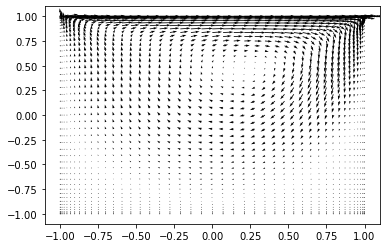

In [15]:
converged = False
count = 0
alfa = 0.5
while not converged:
    count += 1
    bh_hat = compute_rhs(ui_hat, bh_hat)
    uh_new = sol(bh_hat, u=uh_new, constraints=((2, 0, 0),))
    error = np.linalg.norm(ui_hat-ui_new)
    uh_hat[:] = alfa*uh_new + (1-alfa)*uh_hat
    converged = abs(error) < 1e-8 or count >= 100
    print('Iteration %d Error %2.4e' %(count, error))

up = uh_hat.backward()
u, p = up

X = V0.local_mesh(True)
plt.figure()
plt.quiver(X[0], X[1], u[0], u[1])

Note that the `constraints=((2, 0, 0),)` keyword argument
ensures that the pressure integrates to zero, i.e., $\int_{\Omega} p \omega dxdy=0$.
Here the number 2 tells us that block component 2 in the mixed space
(the pressure) should be integrated, dof 0 should be fixed, and it
should be fixed to 0.

The last three lines plots velocity vectors, like also seen in the [figure](#fig:drivencavity)
in the top of this demo. The solution is apparently nice
and smooth, but hidden underneath are Gibbs oscillations from the
corner discontinuities. This is painfully obvious when switching from
Legendre to Chebyshev polynomials. With Chebyshev the same plot looks
like the [Figure](#fig:drivencavitycheb) below. However, choosing instead the
regularized lid, with no discontinuities, the solutions will be nice and
smooth, both for Legendre and Chebyshev polynomials.

<!-- dom:FIGURE: [https://raw.githack.com/spectralDNS/spectralutilities/master/figures/DrivenCavityCheb.png] Velocity vectors for Re=100 using Chebyshev.   <div id="fig:drivencavitycheb"></div> -->
<!-- begin figure -->
<div id="fig:drivencavitycheb"></div>

<p>Velocity vectors for Re=100 using Chebyshev.</p>
<img src="https://raw.githack.com/spectralDNS/spectralutilities/master/figures/DrivenCavityCheb.png" >

<!-- end figure -->



## Complete solver
<div id="sec:nscomplete"></div>

A complete solver can be found in demo [NavierStokesDrivenCavity.py](https://github.com/spectralDNS/shenfun/blob/master/demo/NavierStokesDrivenCavity.py).